In [14]:
import torch
import tqdm
import logger
import numpy as np
import torch.nn as nn
import pickle
import metrics
from skimage import io
from skimage import transform
# from model import FusionNet, DilationCNN, UNet
# from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader
from loss import dice_loss
import imageio


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
import torchvision.models as tormodel
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import glob
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

def mkdir_if_missing(save_dir):
    if os.path.exists(save_dir):
        return 1
    else:
        os.makedirs(save_dir)
        return 0

# Dataloader

In [15]:
import torch.utils.data as data
from PIL import Image
import os

class GetLoader(data.Dataset):
    def __init__(self, data_root, img_folder, lab_folder, transform=None):
        self.img_root = os.path.join(data_root,img_folder)
        self.mask_root = os.path.join(data_root,lab_folder)
        self.transform = transform
        
        data_list = os.listdir(self.img_root)
        self.n_data = len(data_list)

        self.img_paths = []
        self.lab_paths = []

        for data in data_list:
            self.img_paths.append(os.path.join(self.img_root,data))
            self.lab_paths.append(os.path.join(self.mask_root,data))

    def __getitem__(self, item):
        img_pth, lab_pth = self.img_paths[item], self.lab_paths[item]
        imgs = Image.open(img_pth).convert('RGB')
        labels = np.asarray(imageio.imread(lab_pth))

        if self.transform is not None:
            imgs = self.transform(imgs)
#             labels = self.transform(labels)
        return imgs, labels

    def __len__(self):
        return self.n_data


In [16]:
DATA_DIR = '/home/zhangj41/HW/group_proj/Immune_cell'
TRAIN_IMG = 'image_train'
TEST_IMG = 'image_test'
TRAIN_MASK = 'mask_train'
TEST_MASK = 'mask_test'

img_transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
])

'''---train loader---'''
DATASET_TRAIN = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TRAIN_IMG, 
    lab_folder=TRAIN_MASK, 
    transform=img_transform_train
)
DATALOADER_TRAIN = torch.utils.data.DataLoader(
    dataset=DATASET_TRAIN,
    batch_size=50,
    shuffle=True)

'''---test loader---'''
DATASET_TEST = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TEST_IMG, 
    lab_folder=TEST_MASK, 
    transform=img_transform_train
)
DATALOADER_TEST = torch.utils.data.DataLoader(
    dataset=DATASET_TEST,
    batch_size=100,
    shuffle=False)

34


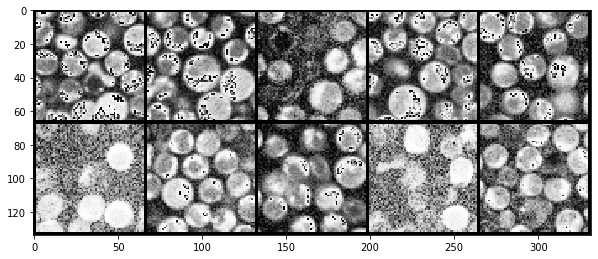

In [17]:
print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
batch_datas, batch_labels = next(iter(DATALOADER_TRAIN)) 
# print(batch_labels)
img = make_grid(batch_datas[0:10], nrow=5, padding=2)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [18]:
# batch_labels_ = batch_labels.unsqueeze(1)
# print(batch_labels_.size())
# img = make_grid(batch_labels_[0:10], nrow=5, padding=2)
# npimg = img.numpy()
# print(npimg.shape)
# plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray', interpolation='nearest')

In [19]:
batch_label = batch_labels[0]
batch_label.size()

torch.Size([64, 64])

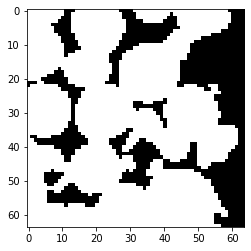

In [20]:
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

# Models

In [21]:
import torch.nn as nn 
import unet_layers as layers


class UNet(nn.Module):
    def __init__(self, num_kernel, kernel_size, dim, target_dim):
        super(UNet, self).__init__()
        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = target_dim

        # encode
        self.encode_1 = layers.DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = layers.DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = layers.DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = layers.DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = layers.UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = layers.UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = layers.UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = layers.UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):
        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)
        pred = self.activate(x)
        return pred

In [22]:
### debug
# batch_datas, batch_labels = next(iter(dataloader_train)) 
# batch_labels.unsqueeze_(1)
# batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()
# unet = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
# unet.cuda()


In [23]:
# loss_function = dice_loss
# pred = unet(batch_datas)
# print(batch_datas.size(), pred.size(), batch_labels.size())
# loss_function(pred, batch_labels)

In [24]:
# print(torch.min(pred),torch.max(pred))
# print(torch.min(batch_labels),torch.max(batch_labels))

# Utils

## Average meter

In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Cell segmentation

In [26]:
class CellSeg:
    def __init__(self, unet):
        self.unet = unet
        self.unet.cuda()
        self.optimizer = torch.optim.SGD(self.unet.parameters(),
                                         lr=0.01, momentum=0.9, weight_decay=1e-3)
    
    def scheduler(self, epoch, lr0=1e-3):
        lr = lr0
        if epoch >= 80:
            lr = lr0 * 0.1
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

            
    def train_batch(self,
                    data_loader,
                    epoch):
        '''--- 1. setup network ---'''
        loss_function = dice_loss
#         total_loss = AverageMeter()
#         total_iou = AverageMeter()
#         total_precision = AverageMeter()
        
        # set train state
        self.unet.train()
        len_dataloader = len(data_loader)
        data_iter = iter(data_loader)

        '''--- 2. train network ---'''
        iters=0
        while iters<len_dataloader-1:
            iters+=1
            input_img, class_label = next(data_iter)
            class_label.unsqueeze_(1)
            input_img, class_label = input_img.cuda(), class_label.cuda()
            batch_size = len(class_label)
            '''forward, compute student ce loss'''
            pred_mask = self.unet(input_img)
            loss = loss_function(pred_mask, class_label)
            
            predictions = pred_mask.clone().squeeze().detach().cpu().numpy()
            gt = class_label.clone().squeeze().detach().cpu().numpy()
            ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
            iou_val = np.mean(ious)
            '''backward teacher generate guided-BP map, detach'''
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if iters%1 == 0:
                print('epoch: {}, [iter {} / all {}], loss:{}, iou:{}'\
                      .format(epoch, iters, len_dataloader, 
                              loss.cpu().data.numpy(),
                              iou_val))
        return loss, iou_val
    
    
    def eval_epoch(self, dataloader):
        cudnn.benchmark = True
        loss_function = dice_loss
        '''---evaluation mode---'''
        self.unet.eval()
        len_dataloader = len(dataloader)
        data_test_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_iou = 0
        total_loss = 0
        total_precision = 0
        counter = 0
#         total_iou = []
        with torch.no_grad():
            while i<len_dataloader:
                # test model using target data
                input_img, class_label = next(data_test_iter)
                class_label.unsqueeze_(1)
                input_img, class_label = input_img.cuda(), class_label.cuda()
                batch_size = len(class_label)

                pred_mask = self.unet(input_img)
                dice_loss_ = loss_function(pred_mask, class_label)
                dice_loss_ = dice_loss_.clone().squeeze().cpu().numpy()
                predictions = pred_mask.clone().squeeze().cpu().numpy()
                gt = class_label.clone().squeeze().cpu().numpy()
                ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
                prec = [metrics.compute_precision(p, g, 0.5) for p,g in zip(predictions, gt)]
#                 total_iou.append(np.mean(ious))
                total_loss += np.sum(dice_loss_)
                total_iou += np.sum(ious)
                total_precision += np.sum(prec)
                counter += batch_size
                i += 1
        iou_avg = total_iou/counter #np.mean(total_iou)
        precision_avg = total_precision/counter
        dice_coeff_avg = 1-total_loss/counter
        print('Normal IOU of the dataset: %f' %(iou_avg))
        print('Normal PREC of the dataset: %f' %(precision_avg))
        print('Normal DICE SCORE of the dataset: %f' %(dice_coeff_avg))
        return iou_avg, precision_avg, dice_coeff_avg
        
        
    def Net_train(self,
                  dl_train,dl_val,
                  n_epochs,
                  save_dir):
        loss_ = []
        iou_val_ = []
        acc_ = []
        for epoch in np.arange(n_epochs):
            # training
            self.scheduler(epoch=epoch)
            loss, iou_val = self.train_batch(data_loader=dl_train,
                                                 epoch=epoch)
            loss_.append(loss)
            iou_val_.append(iou_val)
            # save model
            if epoch>=80:
                file_name = 'unet_epoch'+str(epoch)+'.pth'
                torch.save(self.unet.state_dict(), os.path.join(save_dir,file_name))
            # evaluation
            print('================================================================')
            acc = self.eval_epoch(dataloader=dl_val)
            acc_.append(acc)
            print('================================================================')
        return loss_, iou_val_, acc_

# Main

In [14]:
MODEL_SAVE_PATH = '/home/zhangj41/HW/group_proj/Immune_cell_models'
solver = CellSeg(unet=UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1))
loss_, iou_val_, acc_ = solver.Net_train(dl_train=DATALOADER_TRAIN,
                                         dl_val=DATALOADER_TEST,
                                         n_epochs=100,
                                         save_dir=MODEL_SAVE_PATH)

epoch: 0, [iter 1 / all 34], loss:0.2733829617500305, iou:0.49093329906463623
epoch: 0, [iter 2 / all 34], loss:0.27879488468170166, iou:0.48635023832321167
epoch: 0, [iter 3 / all 34], loss:0.2641364336013794, iou:0.5138928294181824
epoch: 0, [iter 4 / all 34], loss:0.2673766613006592, iou:0.5055822134017944
epoch: 0, [iter 5 / all 34], loss:0.24089205265045166, iou:0.5482960939407349
epoch: 0, [iter 6 / all 34], loss:0.24241316318511963, iou:0.5600626468658447
epoch: 0, [iter 7 / all 34], loss:0.24303936958312988, iou:0.5497923493385315
epoch: 0, [iter 8 / all 34], loss:0.22553837299346924, iou:0.5856729745864868
epoch: 0, [iter 9 / all 34], loss:0.23639339208602905, iou:0.5661218762397766
epoch: 0, [iter 10 / all 34], loss:0.21549147367477417, iou:0.6068520545959473
epoch: 0, [iter 11 / all 34], loss:0.2089465856552124, iou:0.6088592410087585
epoch: 0, [iter 12 / all 34], loss:0.21249479055404663, iou:0.6074450016021729
epoch: 0, [iter 13 / all 34], loss:0.19016700983047485, iou:0.6

epoch: 3, [iter 3 / all 34], loss:0.13587528467178345, iou:0.7143120765686035
epoch: 3, [iter 4 / all 34], loss:0.12271344661712646, iou:0.737273097038269
epoch: 3, [iter 5 / all 34], loss:0.12303692102432251, iou:0.7391439080238342
epoch: 3, [iter 6 / all 34], loss:0.14640438556671143, iou:0.6991260051727295
epoch: 3, [iter 7 / all 34], loss:0.13525009155273438, iou:0.7179809808731079
epoch: 3, [iter 8 / all 34], loss:0.12469881772994995, iou:0.74794602394104
epoch: 3, [iter 9 / all 34], loss:0.13401710987091064, iou:0.7193199396133423
epoch: 3, [iter 10 / all 34], loss:0.11536675691604614, iou:0.7657510638237
epoch: 3, [iter 11 / all 34], loss:0.14391207695007324, iou:0.7012057304382324
epoch: 3, [iter 12 / all 34], loss:0.14316999912261963, iou:0.7020350098609924
epoch: 3, [iter 13 / all 34], loss:0.13006043434143066, iou:0.7190890312194824
epoch: 3, [iter 14 / all 34], loss:0.14052671194076538, iou:0.7081699371337891
epoch: 3, [iter 15 / all 34], loss:0.14733707904815674, iou:0.694

epoch: 6, [iter 3 / all 34], loss:0.12760180234909058, iou:0.7257091999053955
epoch: 6, [iter 4 / all 34], loss:0.1233476996421814, iou:0.7334465980529785
epoch: 6, [iter 5 / all 34], loss:0.11693382263183594, iou:0.7415932416915894
epoch: 6, [iter 6 / all 34], loss:0.12331193685531616, iou:0.725342869758606
epoch: 6, [iter 7 / all 34], loss:0.1327102780342102, iou:0.7109019756317139
epoch: 6, [iter 8 / all 34], loss:0.12330764532089233, iou:0.7368826270103455
epoch: 6, [iter 9 / all 34], loss:0.12567627429962158, iou:0.7289914488792419
epoch: 6, [iter 10 / all 34], loss:0.12859517335891724, iou:0.7265546917915344
epoch: 6, [iter 11 / all 34], loss:0.12314927577972412, iou:0.7276131510734558
epoch: 6, [iter 12 / all 34], loss:0.11795270442962646, iou:0.7444320917129517
epoch: 6, [iter 13 / all 34], loss:0.14775502681732178, iou:0.6878838539123535
epoch: 6, [iter 14 / all 34], loss:0.13064205646514893, iou:0.7177143692970276
epoch: 6, [iter 15 / all 34], loss:0.12312817573547363, iou:0.

epoch: 9, [iter 3 / all 34], loss:0.14175361394882202, iou:0.7085036635398865
epoch: 9, [iter 4 / all 34], loss:0.11577421426773071, iou:0.7411284446716309
epoch: 9, [iter 5 / all 34], loss:0.1173664927482605, iou:0.7445957064628601
epoch: 9, [iter 6 / all 34], loss:0.12857317924499512, iou:0.7178024053573608
epoch: 9, [iter 7 / all 34], loss:0.12440836429595947, iou:0.7390615940093994
epoch: 9, [iter 8 / all 34], loss:0.12437134981155396, iou:0.7220096588134766
epoch: 9, [iter 9 / all 34], loss:0.11947953701019287, iou:0.7436602115631104
epoch: 9, [iter 10 / all 34], loss:0.1118195652961731, iou:0.7542176246643066
epoch: 9, [iter 11 / all 34], loss:0.1210598349571228, iou:0.7375781536102295
epoch: 9, [iter 12 / all 34], loss:0.10879433155059814, iou:0.7605351209640503
epoch: 9, [iter 13 / all 34], loss:0.12508654594421387, iou:0.7071241140365601
epoch: 9, [iter 14 / all 34], loss:0.12964493036270142, iou:0.7258830070495605
epoch: 9, [iter 15 / all 34], loss:0.13842666149139404, iou:0.

epoch: 12, [iter 3 / all 34], loss:0.11952441930770874, iou:0.7304210662841797
epoch: 12, [iter 4 / all 34], loss:0.11577683687210083, iou:0.7420657277107239
epoch: 12, [iter 5 / all 34], loss:0.12224221229553223, iou:0.7357416749000549
epoch: 12, [iter 6 / all 34], loss:0.12305706739425659, iou:0.7317298650741577
epoch: 12, [iter 7 / all 34], loss:0.13075101375579834, iou:0.7219839692115784
epoch: 12, [iter 8 / all 34], loss:0.12703222036361694, iou:0.7294564247131348
epoch: 12, [iter 9 / all 34], loss:0.1279771327972412, iou:0.724174439907074
epoch: 12, [iter 10 / all 34], loss:0.11254376173019409, iou:0.7512222528457642
epoch: 12, [iter 11 / all 34], loss:0.12263357639312744, iou:0.7345958948135376
epoch: 12, [iter 12 / all 34], loss:0.11636453866958618, iou:0.7503376007080078
epoch: 12, [iter 13 / all 34], loss:0.11419147253036499, iou:0.7602500319480896
epoch: 12, [iter 14 / all 34], loss:0.14486175775527954, iou:0.6891106367111206
epoch: 12, [iter 15 / all 34], loss:0.11482036113

epoch: 15, [iter 3 / all 34], loss:0.13057249784469604, iou:0.722076416015625
epoch: 15, [iter 4 / all 34], loss:0.1103823184967041, iou:0.7527310252189636
epoch: 15, [iter 5 / all 34], loss:0.11125153303146362, iou:0.7518975734710693
epoch: 15, [iter 6 / all 34], loss:0.10921859741210938, iou:0.7564902305603027
epoch: 15, [iter 7 / all 34], loss:0.10682433843612671, iou:0.7664999961853027
epoch: 15, [iter 8 / all 34], loss:0.0991353988647461, iou:0.784014880657196
epoch: 15, [iter 9 / all 34], loss:0.10629969835281372, iou:0.7644284963607788
epoch: 15, [iter 10 / all 34], loss:0.11683052778244019, iou:0.7497777342796326
epoch: 15, [iter 11 / all 34], loss:0.13362336158752441, iou:0.724495530128479
epoch: 15, [iter 12 / all 34], loss:0.10297590494155884, iou:0.772423505783081
epoch: 15, [iter 13 / all 34], loss:0.12694984674453735, iou:0.7330967783927917
epoch: 15, [iter 14 / all 34], loss:0.11147886514663696, iou:0.7582553029060364
epoch: 15, [iter 15 / all 34], loss:0.117253303527832

epoch: 18, [iter 3 / all 34], loss:0.13694417476654053, iou:0.6961061358451843
epoch: 18, [iter 4 / all 34], loss:0.1160428524017334, iou:0.7509910464286804
epoch: 18, [iter 5 / all 34], loss:0.11337828636169434, iou:0.7394426465034485
epoch: 18, [iter 6 / all 34], loss:0.10247725248336792, iou:0.7660226225852966
epoch: 18, [iter 7 / all 34], loss:0.10255873203277588, iou:0.772097110748291
epoch: 18, [iter 8 / all 34], loss:0.10350370407104492, iou:0.7764481902122498
epoch: 18, [iter 9 / all 34], loss:0.10082471370697021, iou:0.7646975517272949
epoch: 18, [iter 10 / all 34], loss:0.11956697702407837, iou:0.7454178333282471
epoch: 18, [iter 11 / all 34], loss:0.11356008052825928, iou:0.7562606930732727
epoch: 18, [iter 12 / all 34], loss:0.12276500463485718, iou:0.726539671421051
epoch: 18, [iter 13 / all 34], loss:0.10302937030792236, iou:0.7648208141326904
epoch: 18, [iter 14 / all 34], loss:0.1298609972000122, iou:0.7181432843208313
epoch: 18, [iter 15 / all 34], loss:0.1224085092544

epoch: 21, [iter 3 / all 34], loss:0.10627621412277222, iou:0.7622765898704529
epoch: 21, [iter 4 / all 34], loss:0.12143063545227051, iou:0.7459082007408142
epoch: 21, [iter 5 / all 34], loss:0.105868399143219, iou:0.7603298425674438
epoch: 21, [iter 6 / all 34], loss:0.0974317193031311, iou:0.7798099517822266
epoch: 21, [iter 7 / all 34], loss:0.11204260587692261, iou:0.7510861754417419
epoch: 21, [iter 8 / all 34], loss:0.11592686176300049, iou:0.7460393309593201
epoch: 21, [iter 9 / all 34], loss:0.09978216886520386, iou:0.7747933268547058
epoch: 21, [iter 10 / all 34], loss:0.12019515037536621, iou:0.7447444796562195
epoch: 21, [iter 11 / all 34], loss:0.11244189739227295, iou:0.7651274800300598
epoch: 21, [iter 12 / all 34], loss:0.10687106847763062, iou:0.7659468054771423
epoch: 21, [iter 13 / all 34], loss:0.11000657081604004, iou:0.757570207118988
epoch: 21, [iter 14 / all 34], loss:0.09990906715393066, iou:0.7734349966049194
epoch: 21, [iter 15 / all 34], loss:0.1058727502822

epoch: 24, [iter 3 / all 34], loss:0.10388755798339844, iou:0.7747182250022888
epoch: 24, [iter 4 / all 34], loss:0.11599844694137573, iou:0.7514194250106812
epoch: 24, [iter 5 / all 34], loss:0.09705650806427002, iou:0.7808341383934021
epoch: 24, [iter 6 / all 34], loss:0.11652076244354248, iou:0.7493070363998413
epoch: 24, [iter 7 / all 34], loss:0.10247373580932617, iou:0.774017333984375
epoch: 24, [iter 8 / all 34], loss:0.10738629102706909, iou:0.7708762288093567
epoch: 24, [iter 9 / all 34], loss:0.11084175109863281, iou:0.7709764838218689
epoch: 24, [iter 10 / all 34], loss:0.09858405590057373, iou:0.7801396250724792
epoch: 24, [iter 11 / all 34], loss:0.11003965139389038, iou:0.7621582746505737
epoch: 24, [iter 12 / all 34], loss:0.11692667007446289, iou:0.7478973269462585
epoch: 24, [iter 13 / all 34], loss:0.10310685634613037, iou:0.7704827785491943
epoch: 24, [iter 14 / all 34], loss:0.11435902118682861, iou:0.753030002117157
epoch: 24, [iter 15 / all 34], loss:0.09525012969

epoch: 27, [iter 3 / all 34], loss:0.10238850116729736, iou:0.7748791575431824
epoch: 27, [iter 4 / all 34], loss:0.09427106380462646, iou:0.7944656610488892
epoch: 27, [iter 5 / all 34], loss:0.10853779315948486, iou:0.7646890878677368
epoch: 27, [iter 6 / all 34], loss:0.11344420909881592, iou:0.7422540187835693
epoch: 27, [iter 7 / all 34], loss:0.10405248403549194, iou:0.7820589542388916
epoch: 27, [iter 8 / all 34], loss:0.09858846664428711, iou:0.7875707149505615
epoch: 27, [iter 9 / all 34], loss:0.09556305408477783, iou:0.7933441996574402
epoch: 27, [iter 10 / all 34], loss:0.11477595567703247, iou:0.7474018931388855
epoch: 27, [iter 11 / all 34], loss:0.09599709510803223, iou:0.7784711718559265
epoch: 27, [iter 12 / all 34], loss:0.10831707715988159, iou:0.7681742310523987
epoch: 27, [iter 13 / all 34], loss:0.09897798299789429, iou:0.7710680961608887
epoch: 27, [iter 14 / all 34], loss:0.10423034429550171, iou:0.7679228782653809
epoch: 27, [iter 15 / all 34], loss:0.123992741

epoch: 30, [iter 3 / all 34], loss:0.0921204686164856, iou:0.7963783740997314
epoch: 30, [iter 4 / all 34], loss:0.09047257900238037, iou:0.794299840927124
epoch: 30, [iter 5 / all 34], loss:0.1055917739868164, iou:0.7851284146308899
epoch: 30, [iter 6 / all 34], loss:0.10432052612304688, iou:0.7745919227600098
epoch: 30, [iter 7 / all 34], loss:0.10337144136428833, iou:0.7681302428245544
epoch: 30, [iter 8 / all 34], loss:0.10118663311004639, iou:0.7669636011123657
epoch: 30, [iter 9 / all 34], loss:0.11530059576034546, iou:0.7452355027198792
epoch: 30, [iter 10 / all 34], loss:0.09341615438461304, iou:0.7925919890403748
epoch: 30, [iter 11 / all 34], loss:0.09339010715484619, iou:0.7921290397644043
epoch: 30, [iter 12 / all 34], loss:0.09449225664138794, iou:0.7950527667999268
epoch: 30, [iter 13 / all 34], loss:0.10131430625915527, iou:0.781475305557251
epoch: 30, [iter 14 / all 34], loss:0.10970652103424072, iou:0.7332414388656616
epoch: 30, [iter 15 / all 34], loss:0.1117956638336

epoch: 33, [iter 3 / all 34], loss:0.09759867191314697, iou:0.7853617072105408
epoch: 33, [iter 4 / all 34], loss:0.09771686792373657, iou:0.7835769057273865
epoch: 33, [iter 5 / all 34], loss:0.09383368492126465, iou:0.7849899530410767
epoch: 33, [iter 6 / all 34], loss:0.11585599184036255, iou:0.7424455881118774
epoch: 33, [iter 7 / all 34], loss:0.09325581789016724, iou:0.7957103252410889
epoch: 33, [iter 8 / all 34], loss:0.114163339138031, iou:0.7519546747207642
epoch: 33, [iter 9 / all 34], loss:0.10952264070510864, iou:0.7657866477966309
epoch: 33, [iter 10 / all 34], loss:0.09781348705291748, iou:0.7911049127578735
epoch: 33, [iter 11 / all 34], loss:0.09414404630661011, iou:0.7914302349090576
epoch: 33, [iter 12 / all 34], loss:0.09634435176849365, iou:0.7868987917900085
epoch: 33, [iter 13 / all 34], loss:0.0994107723236084, iou:0.7872918844223022
epoch: 33, [iter 14 / all 34], loss:0.08500903844833374, iou:0.8043665289878845
epoch: 33, [iter 15 / all 34], loss:0.096306264400

epoch: 36, [iter 3 / all 34], loss:0.09903508424758911, iou:0.7727804780006409
epoch: 36, [iter 4 / all 34], loss:0.09736406803131104, iou:0.7859116196632385
epoch: 36, [iter 5 / all 34], loss:0.09730511903762817, iou:0.7778521180152893
epoch: 36, [iter 6 / all 34], loss:0.10415291786193848, iou:0.7710224390029907
epoch: 36, [iter 7 / all 34], loss:0.10050463676452637, iou:0.7732689380645752
epoch: 36, [iter 8 / all 34], loss:0.10940998792648315, iou:0.7589846253395081
epoch: 36, [iter 9 / all 34], loss:0.08958810567855835, iou:0.8005395531654358
epoch: 36, [iter 10 / all 34], loss:0.10253375768661499, iou:0.7830111980438232
epoch: 36, [iter 11 / all 34], loss:0.10421955585479736, iou:0.7709271907806396
epoch: 36, [iter 12 / all 34], loss:0.11789888143539429, iou:0.7544645071029663
epoch: 36, [iter 13 / all 34], loss:0.1032865047454834, iou:0.7750846147537231
epoch: 36, [iter 14 / all 34], loss:0.09487271308898926, iou:0.7949694991111755
epoch: 36, [iter 15 / all 34], loss:0.1018667221

epoch: 39, [iter 3 / all 34], loss:0.08896881341934204, iou:0.7937121391296387
epoch: 39, [iter 4 / all 34], loss:0.0869494080543518, iou:0.8032144904136658
epoch: 39, [iter 5 / all 34], loss:0.10163366794586182, iou:0.777047336101532
epoch: 39, [iter 6 / all 34], loss:0.1248064637184143, iou:0.7367885708808899
epoch: 39, [iter 7 / all 34], loss:0.08287453651428223, iou:0.8091583251953125
epoch: 39, [iter 8 / all 34], loss:0.10087937116622925, iou:0.7792381048202515
epoch: 39, [iter 9 / all 34], loss:0.10311466455459595, iou:0.7690919637680054
epoch: 39, [iter 10 / all 34], loss:0.11316663026809692, iou:0.7528383135795593
epoch: 39, [iter 11 / all 34], loss:0.10058861970901489, iou:0.7787821888923645
epoch: 39, [iter 12 / all 34], loss:0.07972371578216553, iou:0.8179676532745361
epoch: 39, [iter 13 / all 34], loss:0.0963098406791687, iou:0.7917166352272034
epoch: 39, [iter 14 / all 34], loss:0.09604603052139282, iou:0.7929754853248596
epoch: 39, [iter 15 / all 34], loss:0.0813239812850

epoch: 42, [iter 3 / all 34], loss:0.08947831392288208, iou:0.7950419783592224
epoch: 42, [iter 4 / all 34], loss:0.10692644119262695, iou:0.7646642327308655
epoch: 42, [iter 5 / all 34], loss:0.09328222274780273, iou:0.7966278195381165
epoch: 42, [iter 6 / all 34], loss:0.09628564119338989, iou:0.7889241576194763
epoch: 42, [iter 7 / all 34], loss:0.08770781755447388, iou:0.8055455088615417
epoch: 42, [iter 8 / all 34], loss:0.0970202088356018, iou:0.7845358848571777
epoch: 42, [iter 9 / all 34], loss:0.10324102640151978, iou:0.7767508625984192
epoch: 42, [iter 10 / all 34], loss:0.08928930759429932, iou:0.7908142805099487
epoch: 42, [iter 11 / all 34], loss:0.09973359107971191, iou:0.7704179286956787
epoch: 42, [iter 12 / all 34], loss:0.07359552383422852, iou:0.8353919982910156
epoch: 42, [iter 13 / all 34], loss:0.08564352989196777, iou:0.8089966773986816
epoch: 42, [iter 14 / all 34], loss:0.10133469104766846, iou:0.7695726156234741
epoch: 42, [iter 15 / all 34], loss:0.1015193462

epoch: 45, [iter 3 / all 34], loss:0.09034067392349243, iou:0.8048176765441895
epoch: 45, [iter 4 / all 34], loss:0.09093981981277466, iou:0.7925528883934021
epoch: 45, [iter 5 / all 34], loss:0.08294343948364258, iou:0.816265344619751
epoch: 45, [iter 6 / all 34], loss:0.0962904691696167, iou:0.7921389937400818
epoch: 45, [iter 7 / all 34], loss:0.07601326704025269, iou:0.8300974369049072
epoch: 45, [iter 8 / all 34], loss:0.09677129983901978, iou:0.7778667211532593
epoch: 45, [iter 9 / all 34], loss:0.09886455535888672, iou:0.7797126173973083
epoch: 45, [iter 10 / all 34], loss:0.07402187585830688, iou:0.8332096338272095
epoch: 45, [iter 11 / all 34], loss:0.10662990808486938, iou:0.7651750445365906
epoch: 45, [iter 12 / all 34], loss:0.09660601615905762, iou:0.7903434038162231
epoch: 45, [iter 13 / all 34], loss:0.09302753210067749, iou:0.7874998450279236
epoch: 45, [iter 14 / all 34], loss:0.09404623508453369, iou:0.7741075158119202
epoch: 45, [iter 15 / all 34], loss:0.09700584411

epoch: 48, [iter 3 / all 34], loss:0.07498103380203247, iou:0.8252822756767273
epoch: 48, [iter 4 / all 34], loss:0.10234540700912476, iou:0.7800660133361816
epoch: 48, [iter 5 / all 34], loss:0.09137856960296631, iou:0.8009974956512451
epoch: 48, [iter 6 / all 34], loss:0.09712225198745728, iou:0.7856630682945251
epoch: 48, [iter 7 / all 34], loss:0.09524780511856079, iou:0.7785381078720093
epoch: 48, [iter 8 / all 34], loss:0.08514922857284546, iou:0.8089752793312073
epoch: 48, [iter 9 / all 34], loss:0.09615999460220337, iou:0.7984954714775085
epoch: 48, [iter 10 / all 34], loss:0.09265470504760742, iou:0.7942168712615967
epoch: 48, [iter 11 / all 34], loss:0.08134245872497559, iou:0.810441792011261
epoch: 48, [iter 12 / all 34], loss:0.10414236783981323, iou:0.7795551419258118
epoch: 48, [iter 13 / all 34], loss:0.10167884826660156, iou:0.7764323353767395
epoch: 48, [iter 14 / all 34], loss:0.10643696784973145, iou:0.7663644552230835
epoch: 48, [iter 15 / all 34], loss:0.0861756801

epoch: 51, [iter 3 / all 34], loss:0.09967875480651855, iou:0.7848532795906067
epoch: 51, [iter 4 / all 34], loss:0.08689963817596436, iou:0.8075778484344482
epoch: 51, [iter 5 / all 34], loss:0.08900612592697144, iou:0.8067142963409424
epoch: 51, [iter 6 / all 34], loss:0.09334838390350342, iou:0.7932749390602112
epoch: 51, [iter 7 / all 34], loss:0.0829584002494812, iou:0.8216261267662048
epoch: 51, [iter 8 / all 34], loss:0.08794146776199341, iou:0.7896305322647095
epoch: 51, [iter 9 / all 34], loss:0.08240234851837158, iou:0.8212456703186035
epoch: 51, [iter 10 / all 34], loss:0.10008281469345093, iou:0.7794992923736572
epoch: 51, [iter 11 / all 34], loss:0.09767735004425049, iou:0.7865886688232422
epoch: 51, [iter 12 / all 34], loss:0.07496815919876099, iou:0.829214334487915
epoch: 51, [iter 13 / all 34], loss:0.08788502216339111, iou:0.8106578588485718
epoch: 51, [iter 14 / all 34], loss:0.09658533334732056, iou:0.7763399481773376
epoch: 51, [iter 15 / all 34], loss:0.08230435848

epoch: 54, [iter 3 / all 34], loss:0.07821714878082275, iou:0.8220163583755493
epoch: 54, [iter 4 / all 34], loss:0.08044445514678955, iou:0.8082392811775208
epoch: 54, [iter 5 / all 34], loss:0.07367873191833496, iou:0.8291366100311279
epoch: 54, [iter 6 / all 34], loss:0.0936051607131958, iou:0.782436192035675
epoch: 54, [iter 7 / all 34], loss:0.10054105520248413, iou:0.7724975347518921
epoch: 54, [iter 8 / all 34], loss:0.08331286907196045, iou:0.812384843826294
epoch: 54, [iter 9 / all 34], loss:0.08731484413146973, iou:0.8075513243675232
epoch: 54, [iter 10 / all 34], loss:0.09046602249145508, iou:0.8040578961372375
epoch: 54, [iter 11 / all 34], loss:0.10330510139465332, iou:0.781450092792511
epoch: 54, [iter 12 / all 34], loss:0.09057474136352539, iou:0.8003289699554443
epoch: 54, [iter 13 / all 34], loss:0.0760231614112854, iou:0.8285849690437317
epoch: 54, [iter 14 / all 34], loss:0.09988820552825928, iou:0.7754889130592346
epoch: 54, [iter 15 / all 34], loss:0.09649080038070

epoch: 57, [iter 3 / all 34], loss:0.07946145534515381, iou:0.8162152171134949
epoch: 57, [iter 4 / all 34], loss:0.08666741847991943, iou:0.8017576336860657
epoch: 57, [iter 5 / all 34], loss:0.09766966104507446, iou:0.7827473282814026
epoch: 57, [iter 6 / all 34], loss:0.08660721778869629, iou:0.806979775428772
epoch: 57, [iter 7 / all 34], loss:0.10289549827575684, iou:0.7766947746276855
epoch: 57, [iter 8 / all 34], loss:0.09316855669021606, iou:0.790103554725647
epoch: 57, [iter 9 / all 34], loss:0.08312463760375977, iou:0.8143454194068909
epoch: 57, [iter 10 / all 34], loss:0.0945630669593811, iou:0.7957993149757385
epoch: 57, [iter 11 / all 34], loss:0.0867992639541626, iou:0.8062677979469299
epoch: 57, [iter 12 / all 34], loss:0.0964539647102356, iou:0.7863830327987671
epoch: 57, [iter 13 / all 34], loss:0.10232102870941162, iou:0.7612800002098083
epoch: 57, [iter 14 / all 34], loss:0.09456896781921387, iou:0.7987088561058044
epoch: 57, [iter 15 / all 34], loss:0.09169590473175

epoch: 60, [iter 3 / all 34], loss:0.09223252534866333, iou:0.8021912574768066
epoch: 60, [iter 4 / all 34], loss:0.08878928422927856, iou:0.8075680732727051
epoch: 60, [iter 5 / all 34], loss:0.09324204921722412, iou:0.7992128133773804
epoch: 60, [iter 6 / all 34], loss:0.08466517925262451, iou:0.8126001954078674
epoch: 60, [iter 7 / all 34], loss:0.11411648988723755, iou:0.7537477016448975
epoch: 60, [iter 8 / all 34], loss:0.09095501899719238, iou:0.7953717708587646
epoch: 60, [iter 9 / all 34], loss:0.0971331000328064, iou:0.7890750169754028
epoch: 60, [iter 10 / all 34], loss:0.07365447282791138, iou:0.8319036364555359
epoch: 60, [iter 11 / all 34], loss:0.09582722187042236, iou:0.7845009565353394
epoch: 60, [iter 12 / all 34], loss:0.09037315845489502, iou:0.8038951754570007
epoch: 60, [iter 13 / all 34], loss:0.07594877481460571, iou:0.8163903951644897
epoch: 60, [iter 14 / all 34], loss:0.08683007955551147, iou:0.8014680743217468
epoch: 60, [iter 15 / all 34], loss:0.0783426165

epoch: 63, [iter 3 / all 34], loss:0.08985370397567749, iou:0.7932725548744202
epoch: 63, [iter 4 / all 34], loss:0.08890926837921143, iou:0.8084477782249451
epoch: 63, [iter 5 / all 34], loss:0.09878432750701904, iou:0.7858829498291016
epoch: 63, [iter 6 / all 34], loss:0.09557658433914185, iou:0.782775342464447
epoch: 63, [iter 7 / all 34], loss:0.07752025127410889, iou:0.8184332251548767
epoch: 63, [iter 8 / all 34], loss:0.09324711561203003, iou:0.7959440350532532
epoch: 63, [iter 9 / all 34], loss:0.09538441896438599, iou:0.7876486778259277
epoch: 63, [iter 10 / all 34], loss:0.08154410123825073, iou:0.8153661489486694
epoch: 63, [iter 11 / all 34], loss:0.09144377708435059, iou:0.8076165914535522
epoch: 63, [iter 12 / all 34], loss:0.07616150379180908, iou:0.8235700130462646
epoch: 63, [iter 13 / all 34], loss:0.0820041298866272, iou:0.81840980052948
epoch: 63, [iter 14 / all 34], loss:0.08378869295120239, iou:0.8064587116241455
epoch: 63, [iter 15 / all 34], loss:0.0843180418014

epoch: 66, [iter 3 / all 34], loss:0.08664572238922119, iou:0.7997603416442871
epoch: 66, [iter 4 / all 34], loss:0.09226983785629272, iou:0.7868434190750122
epoch: 66, [iter 5 / all 34], loss:0.08559298515319824, iou:0.8089199066162109
epoch: 66, [iter 6 / all 34], loss:0.08779197931289673, iou:0.8025394678115845
epoch: 66, [iter 7 / all 34], loss:0.10458523035049438, iou:0.7743017077445984
epoch: 66, [iter 8 / all 34], loss:0.09003198146820068, iou:0.8007757067680359
epoch: 66, [iter 9 / all 34], loss:0.09531670808792114, iou:0.7906670570373535
epoch: 66, [iter 10 / all 34], loss:0.09015113115310669, iou:0.8018779754638672
epoch: 66, [iter 11 / all 34], loss:0.08155494928359985, iou:0.8183721899986267
epoch: 66, [iter 12 / all 34], loss:0.08331310749053955, iou:0.814626157283783
epoch: 66, [iter 13 / all 34], loss:0.08687162399291992, iou:0.8032076954841614
epoch: 66, [iter 14 / all 34], loss:0.09038645029067993, iou:0.7980843186378479
epoch: 66, [iter 15 / all 34], loss:0.0890557765

epoch: 69, [iter 3 / all 34], loss:0.0881357192993164, iou:0.7997320294380188
epoch: 69, [iter 4 / all 34], loss:0.08233273029327393, iou:0.8197901844978333
epoch: 69, [iter 5 / all 34], loss:0.11242145299911499, iou:0.7535040378570557
epoch: 69, [iter 6 / all 34], loss:0.07145529985427856, iou:0.8366623520851135
epoch: 69, [iter 7 / all 34], loss:0.08486515283584595, iou:0.8176264762878418
epoch: 69, [iter 8 / all 34], loss:0.08904749155044556, iou:0.8044015765190125
epoch: 69, [iter 9 / all 34], loss:0.08858388662338257, iou:0.7931349277496338
epoch: 69, [iter 10 / all 34], loss:0.08155626058578491, iou:0.8118707537651062
epoch: 69, [iter 11 / all 34], loss:0.090473473072052, iou:0.7978978157043457
epoch: 69, [iter 12 / all 34], loss:0.08123999834060669, iou:0.8048921823501587
epoch: 69, [iter 13 / all 34], loss:0.0874529480934143, iou:0.8055283427238464
epoch: 69, [iter 14 / all 34], loss:0.08690661191940308, iou:0.8131901025772095
epoch: 69, [iter 15 / all 34], loss:0.0902021527290

epoch: 72, [iter 3 / all 34], loss:0.09113508462905884, iou:0.7993035912513733
epoch: 72, [iter 4 / all 34], loss:0.0889248251914978, iou:0.8061721920967102
epoch: 72, [iter 5 / all 34], loss:0.08466655015945435, iou:0.8010255694389343
epoch: 72, [iter 6 / all 34], loss:0.08093881607055664, iou:0.821370005607605
epoch: 72, [iter 7 / all 34], loss:0.10205197334289551, iou:0.7739177942276001
epoch: 72, [iter 8 / all 34], loss:0.09267693758010864, iou:0.7941793203353882
epoch: 72, [iter 9 / all 34], loss:0.0843765139579773, iou:0.817226767539978
epoch: 72, [iter 10 / all 34], loss:0.07494980096817017, iou:0.8276020884513855
epoch: 72, [iter 11 / all 34], loss:0.10360604524612427, iou:0.7685026526451111
epoch: 72, [iter 12 / all 34], loss:0.07998603582382202, iou:0.8226279616355896
epoch: 72, [iter 13 / all 34], loss:0.07460492849349976, iou:0.8279811143875122
epoch: 72, [iter 14 / all 34], loss:0.09178853034973145, iou:0.8021655082702637
epoch: 72, [iter 15 / all 34], loss:0.0936529636383

epoch: 75, [iter 3 / all 34], loss:0.0992395281791687, iou:0.7885663509368896
epoch: 75, [iter 4 / all 34], loss:0.07324016094207764, iou:0.8397128582000732
epoch: 75, [iter 5 / all 34], loss:0.08637106418609619, iou:0.8058979511260986
epoch: 75, [iter 6 / all 34], loss:0.08758842945098877, iou:0.8094611167907715
epoch: 75, [iter 7 / all 34], loss:0.08453875780105591, iou:0.8074756860733032
epoch: 75, [iter 8 / all 34], loss:0.07988733053207397, iou:0.8188879489898682
epoch: 75, [iter 9 / all 34], loss:0.08745509386062622, iou:0.8060651421546936
epoch: 75, [iter 10 / all 34], loss:0.0962977409362793, iou:0.7869226932525635
epoch: 75, [iter 11 / all 34], loss:0.10293495655059814, iou:0.7694625854492188
epoch: 75, [iter 12 / all 34], loss:0.07327204942703247, iou:0.819692075252533
epoch: 75, [iter 13 / all 34], loss:0.0992465615272522, iou:0.785575807094574
epoch: 75, [iter 14 / all 34], loss:0.08557182550430298, iou:0.8093370199203491
epoch: 75, [iter 15 / all 34], loss:0.08847045898437

epoch: 78, [iter 3 / all 34], loss:0.0804561972618103, iou:0.8201025128364563
epoch: 78, [iter 4 / all 34], loss:0.08602255582809448, iou:0.8098037242889404
epoch: 78, [iter 5 / all 34], loss:0.09464561939239502, iou:0.7890322208404541
epoch: 78, [iter 6 / all 34], loss:0.09178167581558228, iou:0.7918204665184021
epoch: 78, [iter 7 / all 34], loss:0.09038925170898438, iou:0.7884775400161743
epoch: 78, [iter 8 / all 34], loss:0.08268707990646362, iou:0.8180515170097351
epoch: 78, [iter 9 / all 34], loss:0.06800299882888794, iou:0.8383120894432068
epoch: 78, [iter 10 / all 34], loss:0.08914917707443237, iou:0.7976028919219971
epoch: 78, [iter 11 / all 34], loss:0.07818162441253662, iou:0.8227059841156006
epoch: 78, [iter 12 / all 34], loss:0.0897374153137207, iou:0.804648756980896
epoch: 78, [iter 13 / all 34], loss:0.08371299505233765, iou:0.8059776425361633
epoch: 78, [iter 14 / all 34], loss:0.09814149141311646, iou:0.7926216125488281
epoch: 78, [iter 15 / all 34], loss:0.071940183639

epoch: 81, [iter 3 / all 34], loss:0.07805132865905762, iou:0.8218580484390259
epoch: 81, [iter 4 / all 34], loss:0.09879493713378906, iou:0.7831249833106995
epoch: 81, [iter 5 / all 34], loss:0.09567153453826904, iou:0.7898178100585938
epoch: 81, [iter 6 / all 34], loss:0.07361894845962524, iou:0.8350080847740173
epoch: 81, [iter 7 / all 34], loss:0.08572304248809814, iou:0.807057797908783
epoch: 81, [iter 8 / all 34], loss:0.09460002183914185, iou:0.7944042682647705
epoch: 81, [iter 9 / all 34], loss:0.0807269811630249, iou:0.8221210241317749
epoch: 81, [iter 10 / all 34], loss:0.0968484878540039, iou:0.7939976453781128
epoch: 81, [iter 11 / all 34], loss:0.0925338864326477, iou:0.7989303469657898
epoch: 81, [iter 12 / all 34], loss:0.07447242736816406, iou:0.8243457078933716
epoch: 81, [iter 13 / all 34], loss:0.07359397411346436, iou:0.8370725512504578
epoch: 81, [iter 14 / all 34], loss:0.07690232992172241, iou:0.8249274492263794
epoch: 81, [iter 15 / all 34], loss:0.0890465378761

epoch: 84, [iter 3 / all 34], loss:0.07782584428787231, iou:0.8181184530258179
epoch: 84, [iter 4 / all 34], loss:0.09384512901306152, iou:0.7932758927345276
epoch: 84, [iter 5 / all 34], loss:0.08729052543640137, iou:0.8041785955429077
epoch: 84, [iter 6 / all 34], loss:0.09105229377746582, iou:0.7995553016662598
epoch: 84, [iter 7 / all 34], loss:0.08983355760574341, iou:0.8046621084213257
epoch: 84, [iter 8 / all 34], loss:0.07512402534484863, iou:0.8282307982444763
epoch: 84, [iter 9 / all 34], loss:0.07887566089630127, iou:0.8236947655677795
epoch: 84, [iter 10 / all 34], loss:0.08171659708023071, iou:0.8036653399467468
epoch: 84, [iter 11 / all 34], loss:0.07040667533874512, iou:0.8258988261222839
epoch: 84, [iter 12 / all 34], loss:0.0864708423614502, iou:0.8078740835189819
epoch: 84, [iter 13 / all 34], loss:0.0778493881225586, iou:0.8198748230934143
epoch: 84, [iter 14 / all 34], loss:0.0894208550453186, iou:0.8089897036552429
epoch: 84, [iter 15 / all 34], loss:0.087509095668

epoch: 87, [iter 3 / all 34], loss:0.08516484498977661, iou:0.8131129741668701
epoch: 87, [iter 4 / all 34], loss:0.07398539781570435, iou:0.8352668285369873
epoch: 87, [iter 5 / all 34], loss:0.07303905487060547, iou:0.8337098956108093
epoch: 87, [iter 6 / all 34], loss:0.08816397190093994, iou:0.7995311617851257
epoch: 87, [iter 7 / all 34], loss:0.07713091373443604, iou:0.8186176419258118
epoch: 87, [iter 8 / all 34], loss:0.07994437217712402, iou:0.8210877776145935
epoch: 87, [iter 9 / all 34], loss:0.07737445831298828, iou:0.8270983099937439
epoch: 87, [iter 10 / all 34], loss:0.0824350118637085, iou:0.8053798675537109
epoch: 87, [iter 11 / all 34], loss:0.08489078283309937, iou:0.8103567361831665
epoch: 87, [iter 12 / all 34], loss:0.07780629396438599, iou:0.820025622844696
epoch: 87, [iter 13 / all 34], loss:0.0755918025970459, iou:0.8297775387763977
epoch: 87, [iter 14 / all 34], loss:0.08354181051254272, iou:0.8148369789123535
epoch: 87, [iter 15 / all 34], loss:0.098887979984

epoch: 90, [iter 3 / all 34], loss:0.09481006860733032, iou:0.7927975654602051
epoch: 90, [iter 4 / all 34], loss:0.07938909530639648, iou:0.8219816088676453
epoch: 90, [iter 5 / all 34], loss:0.08962881565093994, iou:0.8074398636817932
epoch: 90, [iter 6 / all 34], loss:0.08924657106399536, iou:0.7997716665267944
epoch: 90, [iter 7 / all 34], loss:0.08281916379928589, iou:0.8121289610862732
epoch: 90, [iter 8 / all 34], loss:0.09189337491989136, iou:0.7912129759788513
epoch: 90, [iter 9 / all 34], loss:0.08767396211624146, iou:0.7986583709716797
epoch: 90, [iter 10 / all 34], loss:0.08051818609237671, iou:0.820768415927887
epoch: 90, [iter 11 / all 34], loss:0.09029173851013184, iou:0.8031900525093079
epoch: 90, [iter 12 / all 34], loss:0.09716367721557617, iou:0.7913610935211182
epoch: 90, [iter 13 / all 34], loss:0.08291435241699219, iou:0.8117461204528809
epoch: 90, [iter 14 / all 34], loss:0.09105455875396729, iou:0.7968444228172302
epoch: 90, [iter 15 / all 34], loss:0.0979824066

epoch: 93, [iter 2 / all 34], loss:0.10363978147506714, iou:0.7811824679374695
epoch: 93, [iter 3 / all 34], loss:0.08795416355133057, iou:0.7980270385742188
epoch: 93, [iter 4 / all 34], loss:0.0844728946685791, iou:0.8021948337554932
epoch: 93, [iter 5 / all 34], loss:0.08421087265014648, iou:0.8100294470787048
epoch: 93, [iter 6 / all 34], loss:0.07861185073852539, iou:0.8166479468345642
epoch: 93, [iter 7 / all 34], loss:0.07396221160888672, iou:0.8297509551048279
epoch: 93, [iter 8 / all 34], loss:0.07146632671356201, iou:0.8338889479637146
epoch: 93, [iter 9 / all 34], loss:0.09294009208679199, iou:0.8001291155815125
epoch: 93, [iter 10 / all 34], loss:0.08994477987289429, iou:0.8008465766906738
epoch: 93, [iter 11 / all 34], loss:0.07917732000350952, iou:0.8153021931648254
epoch: 93, [iter 12 / all 34], loss:0.07822173833847046, iou:0.8167650103569031
epoch: 93, [iter 13 / all 34], loss:0.0974888801574707, iou:0.7878330945968628
epoch: 93, [iter 14 / all 34], loss:0.087483763694

Normal accuracy of the dataset: 0.847035
epoch: 96, [iter 1 / all 34], loss:0.08596163988113403, iou:0.805545449256897
epoch: 96, [iter 2 / all 34], loss:0.08165943622589111, iou:0.821338951587677
epoch: 96, [iter 3 / all 34], loss:0.08908271789550781, iou:0.7936978340148926
epoch: 96, [iter 4 / all 34], loss:0.08089202642440796, iou:0.8210424780845642
epoch: 96, [iter 5 / all 34], loss:0.08782094717025757, iou:0.803438663482666
epoch: 96, [iter 6 / all 34], loss:0.08829087018966675, iou:0.8092585206031799
epoch: 96, [iter 7 / all 34], loss:0.09039628505706787, iou:0.7974841594696045
epoch: 96, [iter 8 / all 34], loss:0.0770673155784607, iou:0.8377681970596313
epoch: 96, [iter 9 / all 34], loss:0.08371567726135254, iou:0.8120830655097961
epoch: 96, [iter 10 / all 34], loss:0.09220689535140991, iou:0.7997286319732666
epoch: 96, [iter 11 / all 34], loss:0.10093426704406738, iou:0.7833548784255981
epoch: 96, [iter 12 / all 34], loss:0.09434962272644043, iou:0.7862313985824585
epoch: 96, [

epoch: 98, [iter 33 / all 34], loss:0.08269423246383667, iou:0.8120967149734497
Normal accuracy of the dataset: 0.847078
epoch: 99, [iter 1 / all 34], loss:0.07410943508148193, iou:0.8257468938827515
epoch: 99, [iter 2 / all 34], loss:0.09171110391616821, iou:0.8021807670593262
epoch: 99, [iter 3 / all 34], loss:0.08901071548461914, iou:0.8073945641517639
epoch: 99, [iter 4 / all 34], loss:0.0731210708618164, iou:0.828748881816864
epoch: 99, [iter 5 / all 34], loss:0.07903099060058594, iou:0.8219661116600037
epoch: 99, [iter 6 / all 34], loss:0.07497543096542358, iou:0.8251350522041321
epoch: 99, [iter 7 / all 34], loss:0.08686786890029907, iou:0.7982287406921387
epoch: 99, [iter 8 / all 34], loss:0.09509050846099854, iou:0.7979869246482849
epoch: 99, [iter 9 / all 34], loss:0.08768665790557861, iou:0.8020899295806885
epoch: 99, [iter 10 / all 34], loss:0.08439737558364868, iou:0.8061033487319946
epoch: 99, [iter 11 / all 34], loss:0.07736331224441528, iou:0.8231242895126343
epoch: 99,

Text(0, 0.5, 'loss')

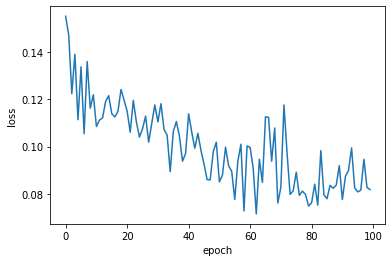

In [19]:
plt.plot(loss_)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'dice coefficient')

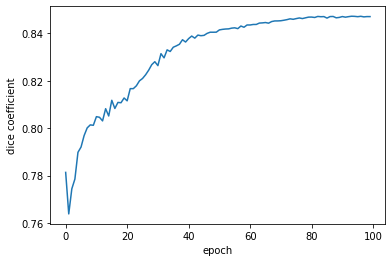

In [20]:
plt.plot(acc_)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')

In [ ]:
model_path = '/home/zhangj41/HW/group_proj/Immune_cell_models/unet_epoch90.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

In [ ]:
batch_datas, batch_labels = next(iter(DATALOADER_TEST)) 
batch_labels.unsqueeze_(1)

print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
img = make_grid(batch_datas[0:10], nrow=5, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()

pred_masks = model(batch_datas)
print(batch_datas.size(), batch_labels.size(), pred_masks.size())

In [ ]:
batch_data = batch_datas[0]
print(batch_data.size())
batch_data = batch_data.cpu().data.numpy()
plt.imshow(np.transpose(batch_data, (1,2,0)), cmap='gray', vmin=0, vmax=1)

In [ ]:
batch_label = batch_labels[0]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

In [ ]:
pred_mask = pred_masks[0]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

In [ ]:
pred_mask[pred_mask>0.5] = 1
pred_mask[pred_mask<=0.5] = 0
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

## Metrics

In [14]:
model_path = '/home/zhangj41/HW/group_proj/Immune_cell_models/unet_epoch90.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

solver = CellSeg(unet=model)
iou_avg, precision_avg, dice_coeff_avg = solver.eval_epoch(dataloader=DATALOADER_TEST)

Normal IOU of the dataset: 0.847090
Normal PREC of the dataset: 0.849741
Normal DICE SCORE of the dataset: 0.999202


## Dice Score

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch

In [22]:
mask_dir = '/home/zhangj41/HW/group_proj/Subplot.png'
mask = imageio.imread(mask_dir)#.astype('uint8')
# mask[:,:,0].shape
mask_np = np.array(mask[:,:,0])
mask_np[mask_np>0] = 1
mask_tensor = torch.Tensor(mask_np)

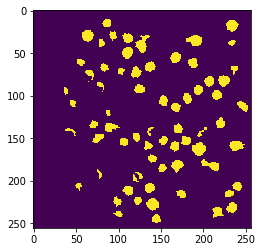

In [23]:
plt.imshow(mask_np)

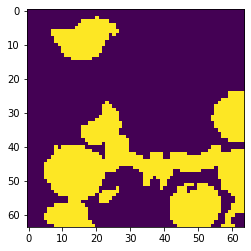

In [20]:
mask_dir = '/home/zhangj41/HW/group_proj/Immune_cell/mask_train/00001.png'
mask = imageio.imread(mask_dir).astype('uint8')
mask[mask>0] = 1
# mask = torch.Tensor(mask)
plt.imshow(mask)

In [4]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch

def dice_loss(pred, target):                                                                         
    smooth = 1.                                                          
                                                                         
    p_flat = pred.contiguous().view(-1)                                   
    t_flat = target.contiguous().view(-1)                                 
    intersection = (p_flat * t_flat).sum()                                 
                                                                         
    a_sum = torch.sum(p_flat * p_flat)                                     
    b_sum = torch.sum(t_flat * t_flat)                                     
                                                                         
    return 1 - ((2. * intersection + smooth) / (a_sum + b_sum + smooth) )

In [5]:
dice_loss(mask, mask)

tensor(0.)

## Whole image

In [27]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
#     plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
    return img_eq

img_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [28]:
model_path = '/home/zhangj41/HW/group_proj/Immune_cell_models/unet_epoch90.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

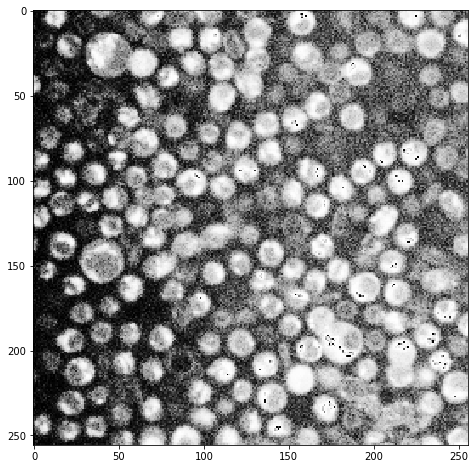

In [29]:
### read the whole image and convert to torch.Tensor
image_loc = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.tiff'
image_save = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.png'
cell_img = img_preprocess(img_dir=image_loc)
cell_img = Image.fromarray(cell_img)
cell_img.save(image_save)

imgs = Image.open(image_save).convert('RGB')
imgs = img_transform(imgs)

npimg = imgs.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([256, 256])


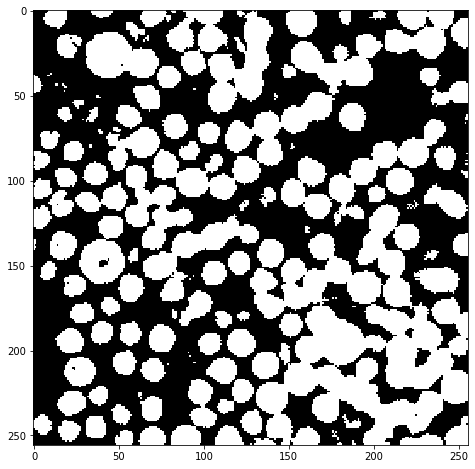

In [30]:
imgs.unsqueeze_(0)
imgs = imgs.cuda()
# imgs.size()

pred_mask = model(imgs)
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
pred_mask[pred_mask>=0.7] = 1
pred_mask[pred_mask<0.7] = 0

plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

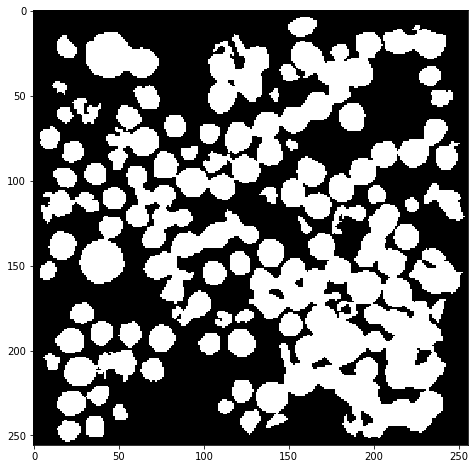

In [32]:
image_loc = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Masks/Tcells_Th0_1n_photons_cells.tiff'
image = imageio.imread(image_loc).astype("uint8")

image[image>0.5] = 1
image[image<=0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=1)